### Imports

In [1]:
import os
import random
from glob import glob

import joblib

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from tqdm import tqdm
from zennit import canonizers as zcanon
from zennit import composites as zcomp
from zennit import core as zcore

from experiment_utils.data import dataloaders, datasets, transforms
from experiment_utils.evaluation import evaluate
from experiment_utils.model import models
from lfprop.propagation import propagator_lxt as propagator
from lfprop.rewards import rewards

/home/lweber/.cache/pypoetry/virtualenvs/lfprop-KukTaqIE-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.environ["WANDB_API_KEY"] = "<tbd>"  # Set your Weights & Biases API key here

dataset_name = "oxford-flowers" #beans #oxford-flowers

project_name = f"leanderweber/lfp-{dataset_name}-vit"
filters = {
    "config.optimizer_name": "adam",
    "config.lr": 0.0002,
}
save_path = f"/media/lweber/f3ed2aae-a7bf-4a55-b50d-ea8fb534f1f51/reward-backprop/resubmission-1-experiments/vit-training-cluster/{dataset_name}/"
history_fields = [
    "epoch",
    "train_micro_accuracy_top1",
    "test_micro_accuracy_top1",
    "total_training_time",
]

savedir = os.path.join(save_path, "saved_runs")
os.makedirs(savedir, exist_ok=True)

In [3]:
import wandb
import pandas as pd

def download_wandb_runs(project, filters, save_dir, run_fields=None, summary_fields=None, history_fields=None):
    """
    Download runs from wandb with given filters, save their performance across epochs to local files.
    If results already exist locally, load and return them.

    Args:
        project (str): wandb project name, e.g. "user/project".
        filters (dict): wandb API filters, e.g. {"config.lr": 0.01, "config.batch_size": 128}.
        save_dir (str): Directory to save results.
        run_fields (list): List of run fields to fetch (optional).
        summary_fields (list): List of summary fields to fetch (optional).
        history_fields (list): List of history fields to fetch (optional).

    Returns:
        dict: {run_id: pd.DataFrame of history}
    """
    os.makedirs(save_dir, exist_ok=True)
    api = wandb.Api()
    runs = api.runs(project, filters=filters)
    results = {}

    for run in runs:
        run_id = run.id
        run_save_path = os.path.join(save_dir, f"{run_id}.csv")
        # if os.path.exists(run_save_path):
        #     df = pd.read_csv(run_save_path)
        # else:
        # Download run history (performance across epochs)
        history = run.history(keys=history_fields)
        df = pd.DataFrame(history)
        df.to_csv(run_save_path, index=False)
        results[run_id] = df

    return results

# Example usage:
results_grad = download_wandb_runs(
    project=project_name,
    filters={**filters, "config.propagator_name": "vanilla-gradient"},
    save_dir=savedir,
    history_fields=history_fields
)

results_lfp = download_wandb_runs(
    project=project_name,
    filters={**filters, "config.propagator_name": "lfp-epsilon"},
    save_dir=savedir,
    history_fields=history_fields
)
results_lfp

{'vwxcqrp0':      _step  epoch  train_micro_accuracy_top1  test_micro_accuracy_top1  \
 0        0      0                   0.016460                  0.012745   
 1        1      1                   0.235458                  0.164706   
 2        2      2                   0.446506                  0.332353   
 3        3      3                   0.400195                  0.257843   
 4        4      4                   0.148556                  0.056863   
 ..     ...    ...                        ...                       ...   
 96      96     96                   0.842795                  0.486275   
 97      97     97                   0.842935                  0.486275   
 98      98     98                   0.842516                  0.486275   
 99      99     99                   0.842516                  0.486275   
 100    100    100                   0.842516                  0.486275   
 
      total_training_time  
 0               0.000000  
 1              40.624155  
 2

In [4]:
# Plot Settings
# Set font properties.
import matplotlib.cm as cm
import matplotlib.font_manager as font_manager

font_path = plt.matplotlib.get_data_path() + "/fonts/ttf/cmr10.ttf"
cmfont = font_manager.FontProperties(fname=font_path)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = cmfont.get_name()
plt.rcParams["mathtext.fontset"] = "cm"

# Set font size.
plt.rcParams["font.size"] = 15

# Disable unicode minus.
plt.rcParams["axes.unicode_minus"] = False

# Use mathtext for axes formatters.
plt.rcParams["axes.formatter.use_mathtext"] = True

plt.rcParams["axes.linewidth"] = 1.5

### Plot Val Accuracies

/tmp/ipykernel_350675/378299940.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


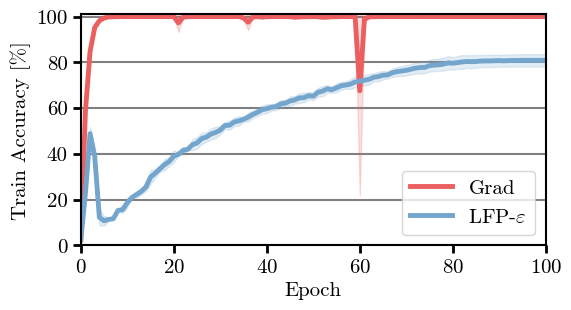

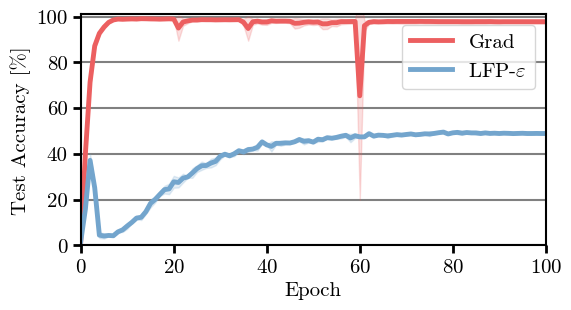

In [5]:
def plot_wandb_accuracies(results_dicts, fname, colormap="Set1", split="test"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    SPLITS = {
        "train": "Train",
        "test": "Test"
    }

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "vanilla-gradient": r"Grad",
    }

    for p, (prop_name, runs) in enumerate(results_dicts.items()):
        plot_data = []
        for run_id, df in runs.items():
            if split == "train":
                plot_data.append(df["train_micro_accuracy_top1"].values)
            else:
                plot_data.append(df["test_micro_accuracy_top1"].values)
        plot_data = np.array(plot_data)
        plot_means = np.mean(plot_data, axis=0)
        plot_stds = np.std(plot_data, axis=0)
        xaxis = np.arange(len(plot_means))

        ax.plot(xaxis, plot_means, color=palette[p], label=LABELS[prop_name], linewidth=3.5, alpha=1)
        ax.fill_between(
            xaxis,
            plot_means + plot_stds,
            plot_means - plot_stds,
            color=palette[p],
            alpha=0.2,
        )

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=xaxis[-1],
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel(f"{SPLITS[split]} Accuracy [%]")
    ax.set_xlabel("Epoch")
    ax.set_ylim([0.0, 1.01])
    ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlim([0.0, xaxis[-1]])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    ax.legend()
    plt.show()
    fig.savefig(fname)

# Prepare the dictionary for plotting
results_dicts = {
    "vanilla-gradient": results_grad,
    "lfp-epsilon": results_lfp,
}

plot_wandb_accuracies(results_dicts, os.path.join(save_path, "accuracies-train.svg"), colormap="Set1", split="train")
plot_wandb_accuracies(results_dicts, os.path.join(save_path, "accuracies-test.svg"), colormap="Set1", split="test")

/tmp/ipykernel_350675/3178543152.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  palette = cm.get_cmap(colormap)(colors)


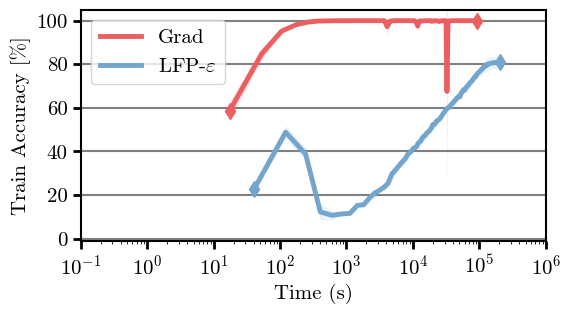

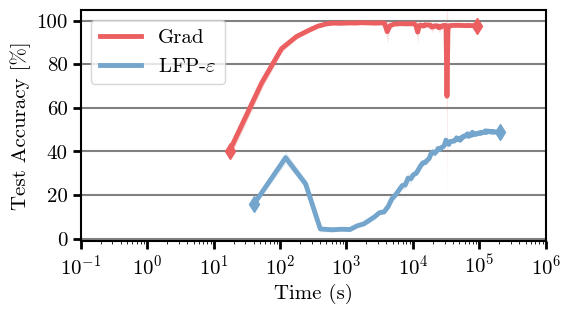

In [6]:
def plot_wandb_accuracies_over_clocktime(results_dicts, fname, colormap="Set1", split="test"):
    fig, ax = plt.subplots(1, 1, figsize=(6, 3))

    colors = np.linspace(0, 1, 9)
    palette = cm.get_cmap(colormap)(colors)
    pastel = 0.3
    palette = (1 - pastel) * palette + pastel * np.ones((9, 4))

    SPLITS = {
        "train": ("train_micro_accuracy_top1", "Train Accuracy [%]"),
        "test": ("test_micro_accuracy_top1", "Test Accuracy [%]")
    }

    LABELS = {
        "lfp-epsilon": r"LFP-$\varepsilon$",
        "vanilla-gradient": r"Grad",
    }

    for p, (prop_name, runs) in enumerate(results_dicts.items()):
        plot_vals = []
        times = []
        for run_id, df in runs.items():
            acc_key = SPLITS[split][0]
            acc = df[acc_key].values[1:]  # skip the first value
            time = df["total_training_time"].values[1:]  # skip the first value
            plot_vals.append(acc)
            times.append(np.cumsum(time))
        plot_vals = np.array(plot_vals)
        times = np.array(times)
        plot_means = np.mean(plot_vals, axis=0)
        times_mean = np.mean(times, axis=0)
        plot_stds = np.std(plot_vals, axis=0)
        times_stds = np.std(times, axis=0)

        # Plot the mean curve
        ax.plot(
            times_mean, plot_means,
            color=palette[p],
            label=LABELS[prop_name],
            linewidth=3.5,
            alpha=1.0
        )
        # Plot marker for the first value
        ax.plot(
            times_mean[0], plot_means[0],
            marker="d",
            color=palette[p],
            markersize=8,
            linestyle="None",
            alpha=1.0
        )
        # Plot marker for the last value
        ax.plot(
            times_mean[-1], plot_means[-1],
            marker="d",
            color=palette[p],
            markersize=8,
            linestyle="None",
            alpha=1.0
        )
        # Plot 2D standard deviation as a shaded region
        ax.fill_betweenx(
            plot_means,
            times_mean - times_stds,
            times_mean + times_stds,
            color=palette[p],
            alpha=0.15,
            linewidth=0
        )
        ax.fill_between(
            times_mean,
            plot_means - plot_stds,
            plot_means + plot_stds,
            color=palette[p],
            alpha=0.15,
            linewidth=0
        )

    linelocs = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
    logxmax = 10 ** np.ceil(np.log10(ax.get_xlim()[1] if ax.get_xlim()[1] > 0 else 1))

    ax.hlines(
        linelocs,
        xmin=-1,
        xmax=logxmax,
        color=(0.5, 0.5, 0.5, 1),
        linewidth=1.5,
        zorder=0,
    )

    ax.set_ylabel(SPLITS[split][1])
    ax.set_xlabel("Time (s)")
    ax.set_yticks(linelocs)
    ax.set_ylim([-0.01, 1.05])
    ax.set_yticklabels([0, 20, 40, 60, 80, 100])
    ax.tick_params(length=6, width=2)
    ax.set_xlim([0.1, logxmax])
    #ax.legend(bbox_to_anchor=(1.0, 1.05))
    ax.legend()
    ax.set_xscale("log")
    plt.show()
    fig.savefig(fname)

plot_wandb_accuracies_over_clocktime(
    results_dicts,
    os.path.join(save_path, "accuracies-over-clocktime-train.svg"),
    colormap="Set1",
    split="train"
)
plot_wandb_accuracies_over_clocktime(
    results_dicts,
    os.path.join(save_path, "accuracies-over-clocktime-test.svg"),
    colormap="Set1",
    split="test"
)